In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from os import readlink
from pathlib import Path
from astropy.io import fits
import h5py
from copy import deepcopy
from matplotlib import colors
from       matplotlib.widgets        import  Slider


import sys
if sys.path[0]:
    # if ran as a script, append the parent dir to the path
    sys.path.append(os.path.dirname(sys.path[0]))
else:
    # if ran interactively, append the parent manually as sys.path[0] 
    # will be emtpy.
    sys.path.append('..')
sys.path.append('..')
    
# import cosmouline stuff
from config import dbbudir, imgdb, settings, configdir, computer,\
                   psfsfile, extracteddir
from modules.variousfct import proquest, readimagelist, mterror,\
                               backupfile, notify
from modules.kirbybase import KirbyBase
from settings_manager import importSettings

db = KirbyBase(imgdb)  

askquestions = settings['askquestions']
workdir = settings['workdir']
decname = settings['decname']
decnormfieldname = settings['decnormfieldname']
decpsfnames = settings['decpsfnames']
decobjname = settings['decobjname']
refimgname_per_band = settings['refimgname_per_band']
setnames = settings['setnames']

    
# deconvolution identifiers. Lists because one per setname.
deckeyfilenums, deckeynormuseds, deckeys, decdirs,\
           decfiles, decskiplists, deckeypsfuseds, ptsrccats = importSettings('lens')

# the most important one is probably "decfiles", which is a list of hdf5 files (one per setname)
# containing all the data needed for the deconvolution



### Config dir: /storage/COSMOGRAIL/VST_WG0214-2105/config/ ###


In [2]:
# import starred stuff
from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss
from starred.utils.optimization import Optimizer
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.plots.plot_function import view_deconv_model

In [3]:
# Parameters
M = 4 # number of point sources 
method = 'trust-constr'
method_ada = 'adabelief'
# lambdas normalized in weight map.
lambda_scales = 1.
lambda_hf = 1.
convolution_method = 'fft'

## Tune background and image positions with best seeing frames

In [4]:
# get data
def getData(decfile):
    with h5py.File(decfile, 'r') as f:
        data = np.array(f['stamps'])
        noisemap = np.array(f['noisemaps'])
        s = np.array(f['psfs'])
    
    im_size = data.shape[1]
    im_size_up = s.shape[1]
    epochs = data.shape[0]
    subsampling_factor = im_size_up // im_size
    
    return data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs)
        
    

In [5]:
decfiles

['/storage/COSMOGRAIL/VST_WG0214-2105/dec_r_SDSS_back_lens_renorm_acdefghijkl_abcdefghijk/stamps-noisemaps-psfs.h5']

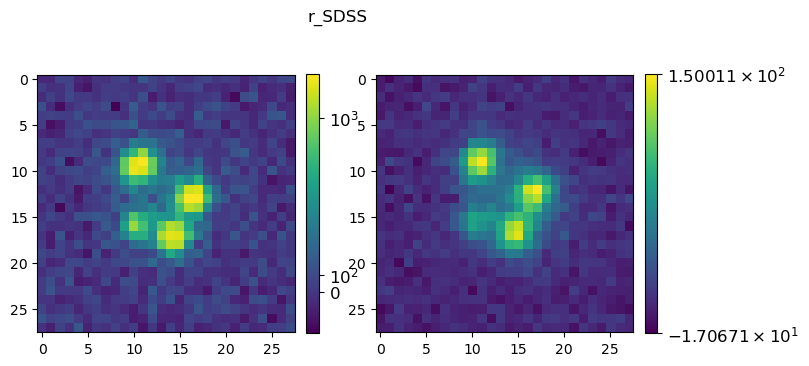

In [6]:
# see the frist two stamps
for setname, decfile in zip(setnames, decfiles):
    data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs) = getData(decfile)
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    fraction = 0.046
    pad = 0.04
    plt.suptitle(setname)
    plt.rc('font', size=12)           
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[1].tick_params(axis='both', which='major', labelsize=10)

    fig.colorbar(axs[0].imshow(data[0,:,:],
                               norm=colors.SymLogNorm(linthresh=1e3)),
                               ax=axs[0], fraction=fraction, pad=pad)
    fig.colorbar(axs[1].imshow(data[1,:,:]/noisemap[1,:,:]**0.5,
                               norm=colors.SymLogNorm(linthresh=1e3)), 
                               ax=axs[1], fraction=fraction, pad=pad)
    plt.show()

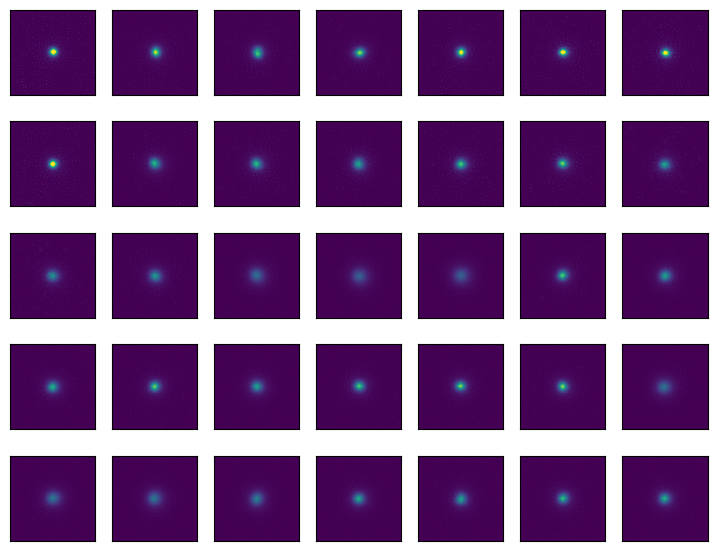

In [7]:
# see some psfs
fig, axs = plt.subplots(5,7, figsize=(9,7))
norm = np.percentile(s, 99.99)
crop = 1
for im, ax in zip(s, axs.flatten()):
    ax.imshow(im[crop:-crop, crop:-crop], vmin=0, vmax=norm, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])

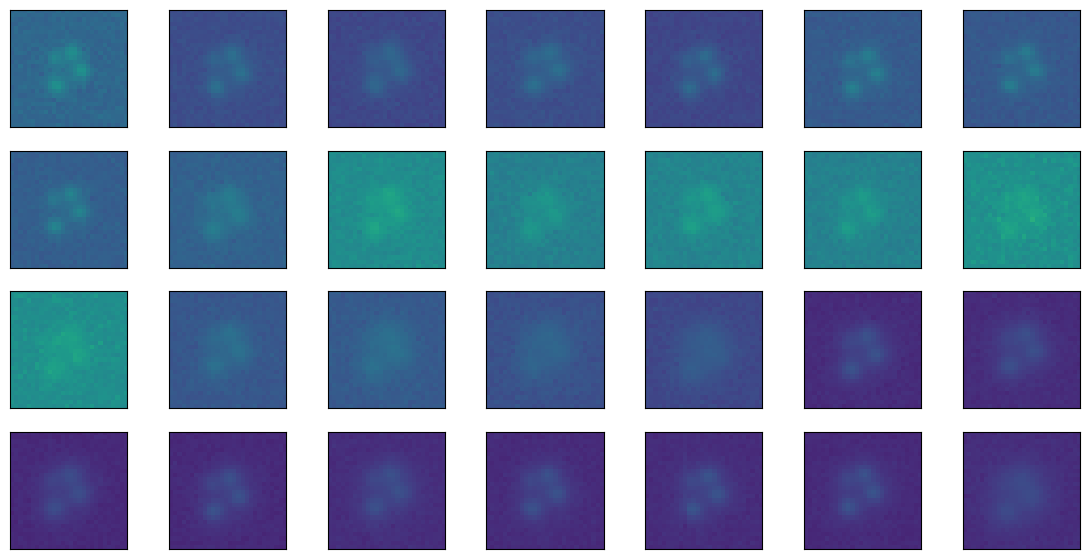

In [8]:
# see some noise maps
fig, axs = plt.subplots(4,7, figsize=(14,7))
norm = np.percentile(noisemap, 99.9)
for im, ax in zip(noisemap, axs.flatten()):
    ax.imshow(im, origin='lower', vmin=0, vmax=norm)
    ax.set_xticks([])
    ax.set_yticks([])

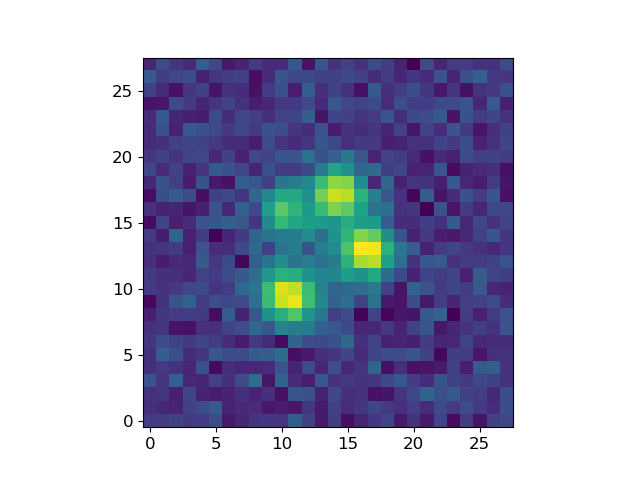

In [9]:
%matplotlib widget
plt.figure()
plt.imshow(np.abs(data[0,:,:])**0.5, origin='lower')
plt.show()

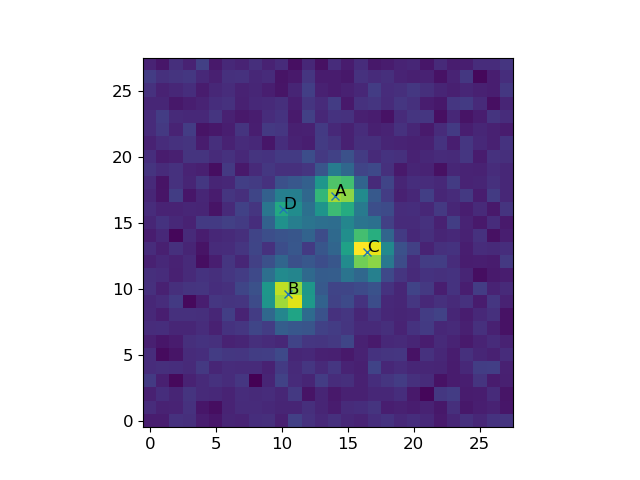

In [10]:
# image positions (read these from a matplotlib plot above)
off = (im_size-1) / 2. # removing im_size / 2 because starred has (0,0) = center
# you will probably need to adjust your offset
imgs = {'A': (14.04, 17.02),
        'B': (10.44, 9.60),
        'C': (16.43, 12.76),
        'D': (10.09, 16.01)}
        #'b': (31.32, 32.49)}


xs = np.array([imgs[im][0] for im in 'ABCD'])
ys = np.array([imgs[im][1] for im in 'ABCD'])

plt.figure()
plt.imshow(data[0,:,:], origin='lower')
plt.plot(xs, ys, 'x')
for n, x, y in zip('ABCD', xs, ys):
    plt.text(x, y, n)

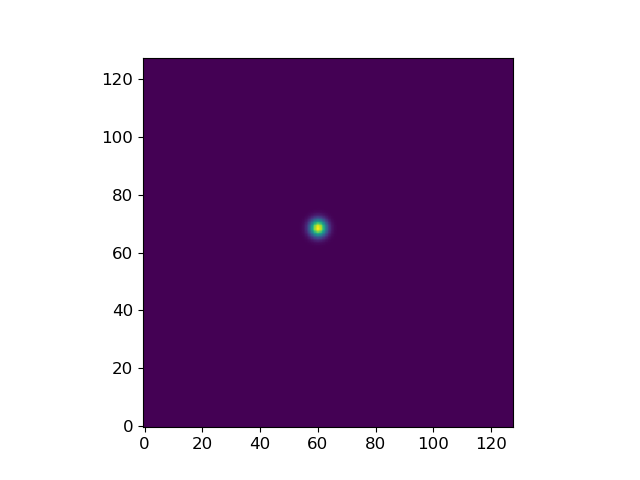

In [11]:

# let's estimate a background :)
# in case you have one ...here no, so we'll set h_est t0 zero.

def generate_2D_gaussian(size, center, sigma=2):
    """
    Function to generate a 2D Gaussian array.
    COURTESY OF CHATGPT-4 THANKS BRO
    
    Args:
        size (tuple): The size of the Gaussian array in the form (rows, columns).
        center (tuple): The position of the center of the Gaussian in the form (row_position, column_position).

    Returns:
        ndarray: A 2D Gaussian array.
    """
    import numpy as np
    from scipy.stats import multivariate_normal

    # Define the mean and covariance matrix
    mean = np.array(center)
    cov = np.eye(2) * sigma**2

    # Create a coordinate grid
    x = np.linspace(0, size[0] - 1, size[0])
    y = np.linspace(0, size[1] - 1, size[1])
    x, y = np.meshgrid(x, y)

    # Stack the coordinates for the multivariate_normal function
    pos = np.dstack((x, y))

    # Create the multivariate normal distribution
    rv = multivariate_normal(mean, cov)

    # Return the 2D Gaussian array
    return rv.pdf(pos)

# (not used here)
x_im, y_im = 30.06, 34.19 # read from the position of the lensing galaxy in the plot above

# 35000: estimate a flux, trial and error.       # factor 2: supersampling.
h_est = 35000* generate_2D_gaussian((128, 128), (2*x_im, 2*y_im))
plt.figure()
plt.imshow(h_est, origin='lower')
# we won't use h_est

In [12]:
help(setup_model)

Help on function setup_model in module starred.deconvolution.deconvolution:

setup_model(data, sigma_2, s, xs, ys, subsampling_factor, initial_a=None, astrometric_bound=None, dithering_bound=None, convolution_method='scipy')
    Utility setting up a deconvolution model. The returned dictionaries of
    parameters can later be adjusted by the user. 
    
    :param data: 3D array containing the images, one per epoch. shape (epochs, im_size, im_size)
    :param sigma_2: 3D array containing the noisemaps, one per epoch. shape (epochs, im_size, im_size)
    :param s: 3D array containing the narrow PSFs, one per epoch. shape (epochs, im_size_up, im_size_up) where im_size_up needs be a multiple of im_size.
    :param xs: 1D array or list containing the x positions of the point sources. For M point sources, len(xs) is M. In unit of big pixel.
    :param ys: 1D array or list containing the y positions of the point sources. For M point sources, len(ys) is M. In unit of big pixel.
    :param ini

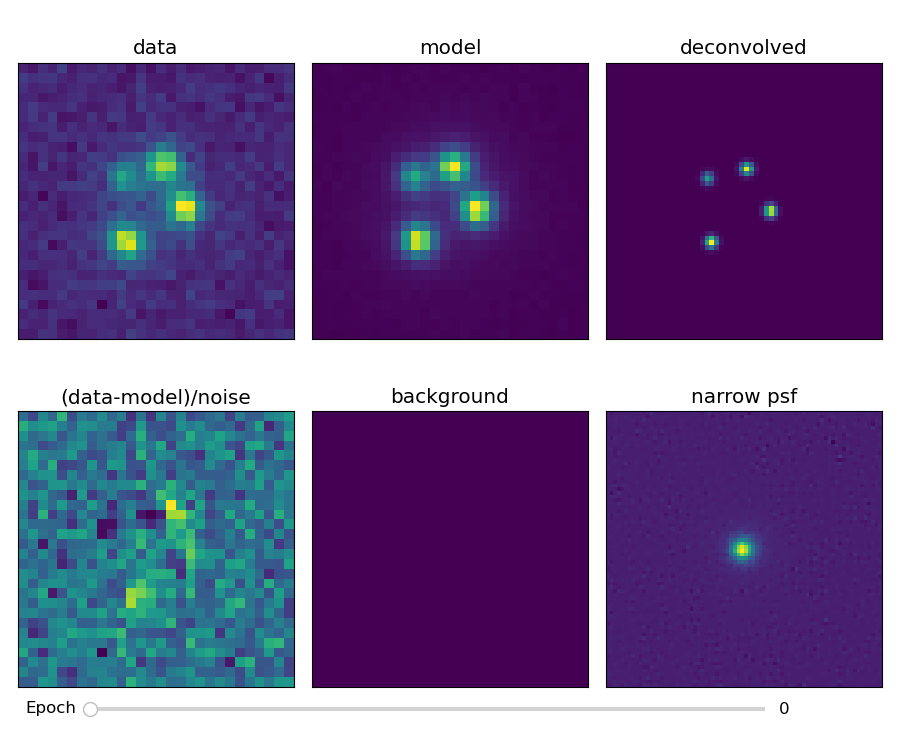

In [13]:
# Parameter initialization

# image positions (read these from a matplotlib plot above)
off = (im_size-1) / 2. # removing im_size / 2 because starred has (0,0) = center

initial_c_x = xs - off
initial_c_y = ys - off 
initial_a = [15000., 16000., 16000., 9000.]
initial_a = epochs*[1.5 * e for e in initial_a]
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       noisemap**2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       subsampling_factor,
                                                                       initial_a)




#kwargs_init['kwargs_background']['h'] = h_est.flatten()
# first look at what our model is like given our initial guess:
view_deconv_model(model, kwargs_init, data, noisemap**2)


In [14]:
# compute noise level in starlet space
# MAKE SURE TO USE A NOISEMAP WITHOUT WEIRD THINGS
# (e.g., masked region with huge values)
W = propagate_noise(model, noisemap[1:], kwargs_init, wavelet_type_list=['starlet'], 
                    method='MC', num_samples=500, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]
#plt.figure()
#plt.imshow(W[0])

# HERE CHOOSE THE CELL YOU NEED
either 
- optimize everything at once immediately
- or optimize only point sources
- or opitmize only backgorund

/home/fred/Documents/starred/starred/deconvolution/loss.py:130: UserWarning: lambda is not normalized. Provide the weight map !
  warnings.warn('lambda is not normalized. Provide the weight map !')
optax.adabelief: 100%|██████████████████████| 1500/1500 [00:24<00:00, 61.29it/s]


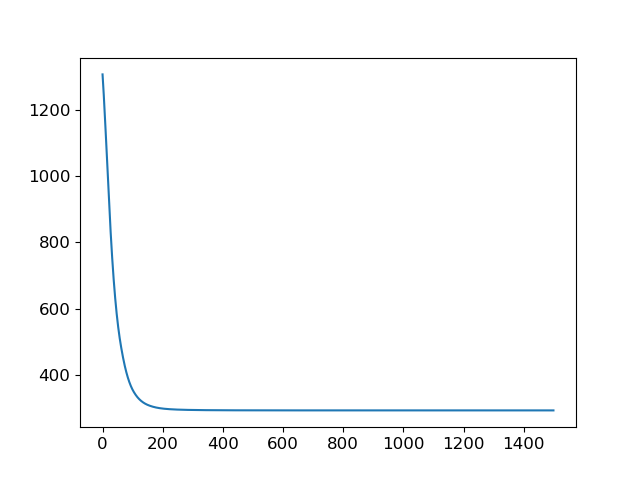

In [14]:
# Point source tuning

kwargs_fixed = {
    'kwargs_analytic': {},
    'kwargs_background':  {'h': kwargs_init['kwargs_background']['h']},
}

parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=10., 
            regularization_strength_hf=10.) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':1500, 'min_iterations':None,
                            'init_learning_rate':4e-3, 'schedule_learning_rate':True,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
#best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(maxiter=500)
kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))

plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()


In [185]:
# Background tunning

# here we fix the positions and intensites of point sources,
# and only allow for the background to vary. 
# (pre-requisite: our initial guess is good, so we can just bring up the 
#  background without worrying about the point sources)
#kwargs_fixed = {
#    'kwargs_analytic': {
#        'c_x': initial_c_x, 
#        'c_y': initial_c_y, 
#        'a'  : initial_a
#    },
#    'kwargs_background': {},
#}
#
#parameters = ParametersDeconv(model, 
#                              kwargs_init=kwargs_init, 
#                              kwargs_fixed=kwargs_fixed, 
#                              kwargs_up=kwargs_up, 
#                              kwargs_down=kwargs_down)
#
#loss = Loss(data, model, parameters, noisemap**2, 
#            regularization_terms='l1_starlet', 
#            regularization_strength_scales=1., 
#            regularization_strength_hf=1., W=W) 
#
#optim = Optimizer(loss, parameters, method='adabelief')
#
#
#optimiser_optax_option = {
#                            'max_iterations':9000, 'min_iterations':None,
#                            'init_learning_rate':1e-4, 'schedule_learning_rate':True,
#                            'restart_from_init':True, 'stop_at_loss_increase':False,
#                            'progress_bar':True, 'return_param_history':True
#                          }           
#
#best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
#
#kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))
#
#
#

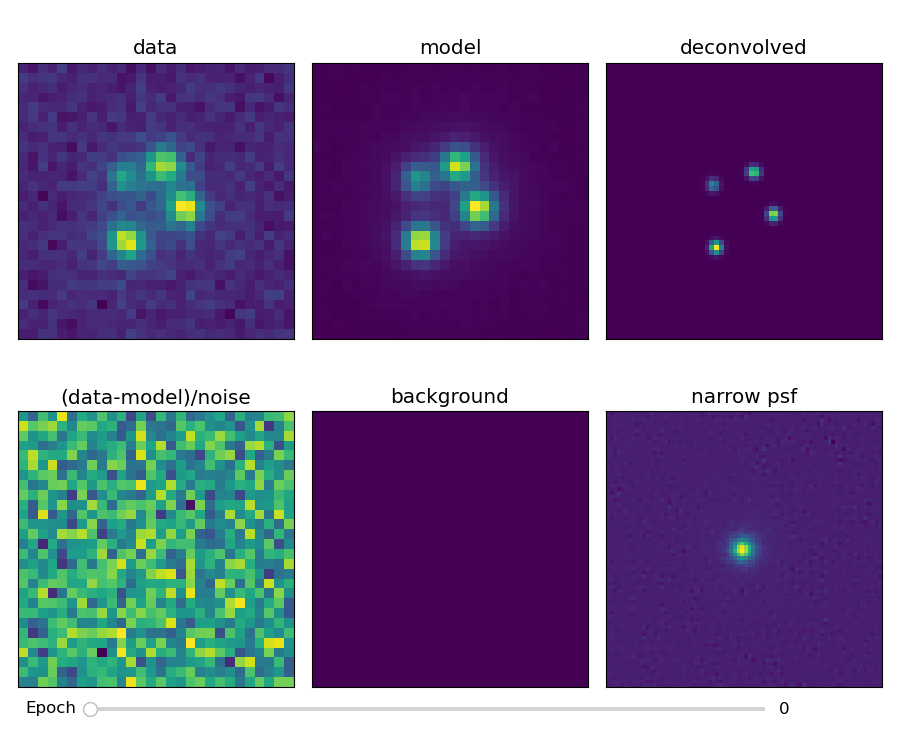

In [18]:
view_deconv_model(model, kwargs_partial, data, noisemap**2)

optax.adabelief: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 91.29it/s]


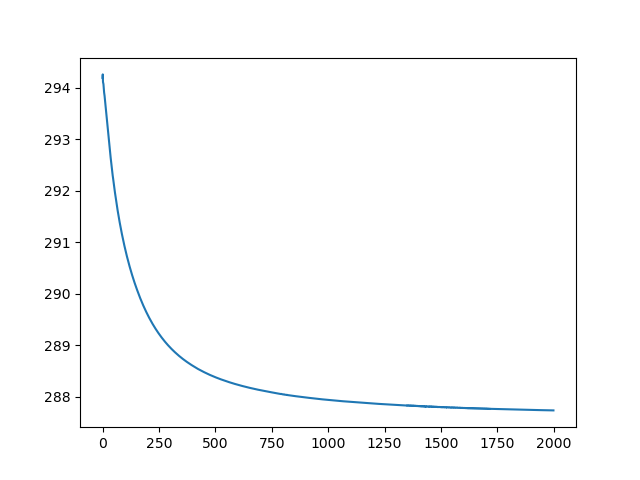

In [31]:
# Background tunning

# here we fix the positions and intensites of point sources,
# and only allow for the background to vary. 

kwargs_fixed = {
    'kwargs_analytic': {
        'c_x': kwargs_partial['kwargs_analytic']['c_x'], 
        'c_y': kwargs_partial['kwargs_analytic']['c_y'], 
    },
    'kwargs_background': {},
}

parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1, 
            regularization_strength_hf=1, W=W) 

optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':2000, 'min_iterations':None,
                            'init_learning_rate':1e-2, 'schedule_learning_rate':True,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)

kwargs_partial2 = deepcopy(parameters.best_fit_values(as_kwargs=True))


plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()


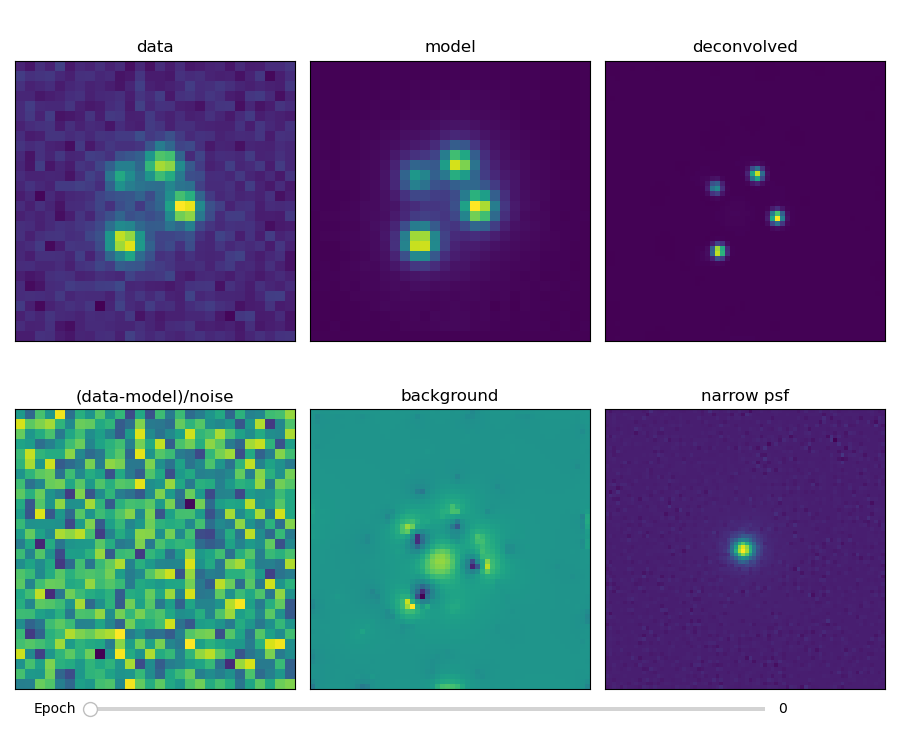

In [32]:
view_deconv_model(model, kwargs_partial2, data, noisemap**2)

optax.adabelief: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:39<00:00, 100.03it/s]


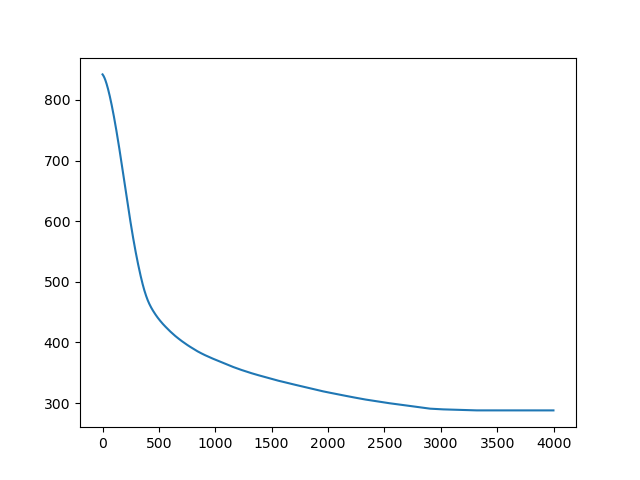

In [40]:
# final tuning: allow everything to be optimized at once.
kwargs_fixed = {
    'kwargs_analytic': {
    },
    'kwargs_background': {},
}

parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1.0, 
            regularization_strength_hf=1.0, 
            regularization_strength_positivity=0.1,
            W=W) 

optimstr = 'adabelief'
if optimstr == 'adabelief':
    optim = Optimizer(loss, parameters, method='adabelief')


    optimiser_optax_option = {
                                'max_iterations':1000, 'min_iterations':None,
                                'init_learning_rate':1e-3, 'schedule_learning_rate':False,
                                'restart_from_init':True, 'stop_at_loss_increase':False,
                                'progress_bar':True, 'return_param_history':True
                              }           

    best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
elif optimstr == 'l-bfgs-b':
    optim = Optimizer(loss, parameters, method='LBFGS')

        
    best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(maxiter=100)

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
# checking how the loss behaved ...
plt.figure()
plt.plot(optim.loss_history)
plt.show()

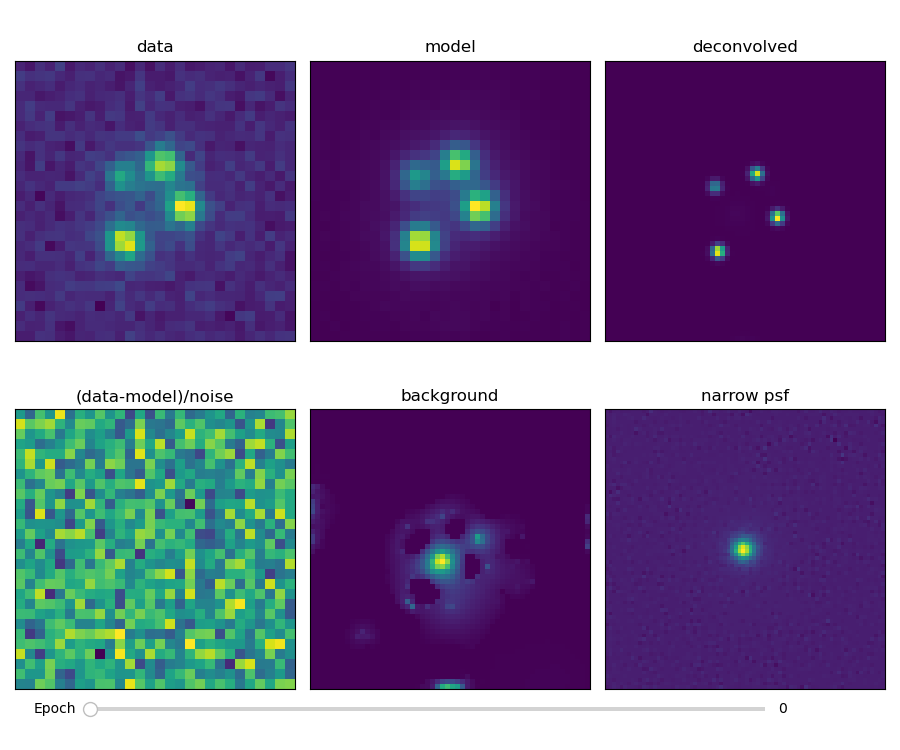

In [41]:
view_deconv_model(model, kwargs_final, data, noisemap**2)

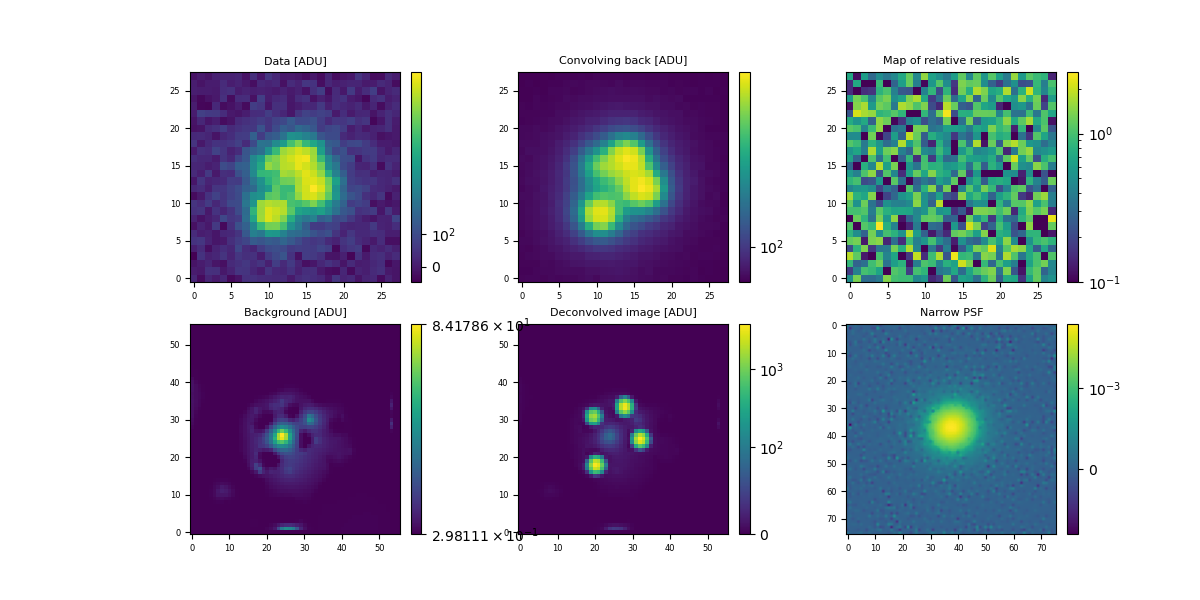

In [43]:
# Retrieving different elements of the deconvolved image
epoch = 80
output = model.model(kwargs_final)[epoch] 
deconv, h = model.getDeconvolved(kwargs_final, epoch)

data_show = data[epoch,:,:] 

dif = data_show - output
rr = np.abs(dif) / np.sqrt((noisemap**2)[epoch,:,:])

fig, axs = plt.subplots(2, 3, figsize=(12,6))
fraction = 0.046
pad = 0.04
font_size = 10
ticks_size = 6

plt.rc('font', size=font_size)           
axs[0,0].set_title('Data [ADU]', fontsize=8)
axs[0,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,1].set_title('Convolving back [ADU]', fontsize=8)
axs[0,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,2].set_title('Map of relative residuals', fontsize=8)
axs[0,2].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,0].set_title('Background [ADU]', fontsize=8)
axs[1,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,1].set_title('Deconvolved image [ADU]', fontsize=8)
axs[1,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,2].set_title('Narrow PSF', fontsize=8)
axs[1,2].tick_params(axis='both', which='major', labelsize=ticks_size)

fig.colorbar(axs[0,0].imshow(data_show,origin='lower', norm=colors.SymLogNorm(linthresh=5e2)), ax=axs[0,0], fraction=fraction, pad=pad)
fig.colorbar(axs[0,1].imshow(output,origin='lower', norm=colors.SymLogNorm(linthresh=5e2)), ax=axs[0,1], fraction=fraction, pad=pad) 
fig.colorbar(axs[0,2].imshow(rr,origin='lower', norm=colors.LogNorm(vmin=0.1)), ax=axs[0,2], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,0].imshow(h, norm=colors.SymLogNorm(linthresh=5e2), origin='lower'), ax=axs[1,0], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,1].imshow(deconv, norm=colors.SymLogNorm(linthresh=1e2), origin='lower'), ax=axs[1,1], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,2].imshow(s[epoch,:,:], norm=colors.SymLogNorm(linthresh=1e-3)), ax=axs[1,2], fraction=fraction, pad=pad);

In [15]:
# intensities
A = kwargs_partial['kwargs_analytic']['a']
curves = []
M = 4
for i in range(M):
    curves.append(A[i::M]*model.scale)
    

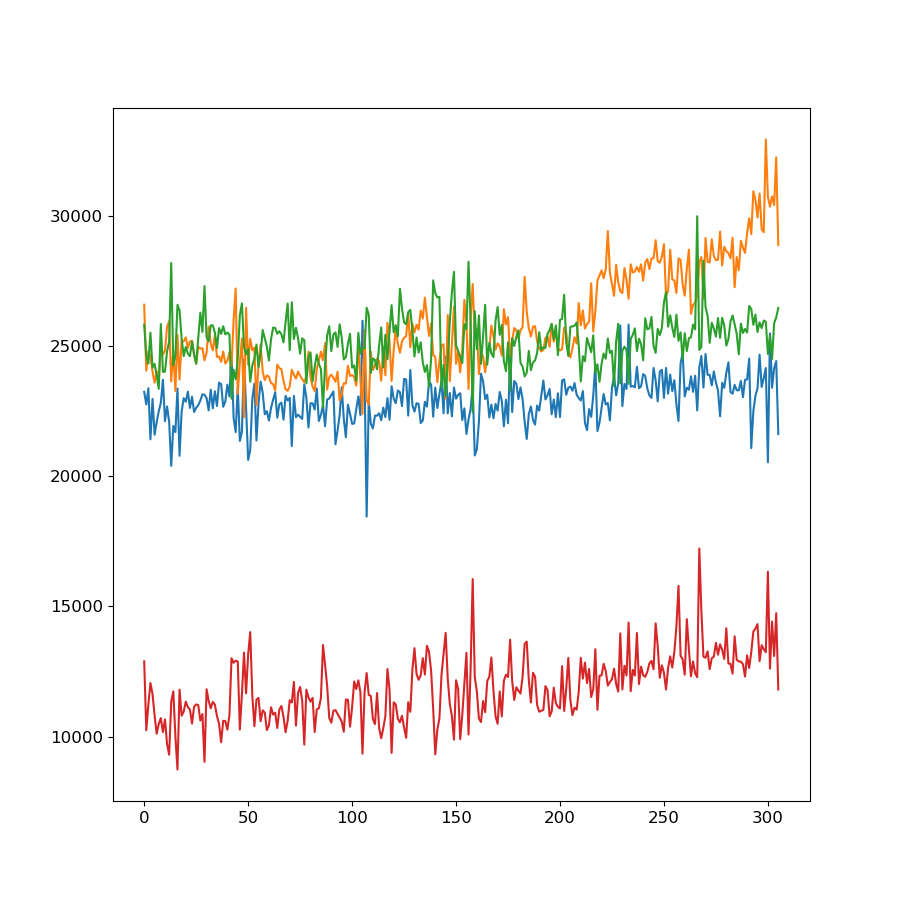

In [16]:
# make sure there's nothing fishy:
plt.figure(figsize=(9,9))
for i in range(M):
    plt.plot(curves[i], label='ABCDb'[i])
plt.show()
plt.legend()

In [17]:
# write the light curves.
with h5py.File(decfile, 'r+') as f:
    if 'light_curves' in f.keys():
        del f['light_curves']
    f['light_curves'] = np.array(curves)